##**Recommender System based on user’s texting Behavior** 
To develop a feature matrix for users based on their texting behaviour and build a recommender system model to identify the closest set of people based on their matrix.

**Data Dictionary** 
- ids: The id of the tweet ( 2087)
- date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- user: the user that tweeted (robotickilldozr)
- text: the text of the tweet (Lyx is cool)



###**Data Preparation, Feature Engineering and Exploratory Data Analysis**<br>

#### **Importing  Libraries**

In [1]:
!pip3 install emoji
!pip3 install emojis
!pip3 install spacy_langdetect 
!pip3 install unidecode 
!pip3 install spacy_langdetect 
!pip3 install better_profanity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import string
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')


In [3]:
# NLP library
import re
import emoji
import emojis

import nltk
import math
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus.reader import wordnet
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


from textblob import TextBlob
from better_profanity import profanity

from unidecode import unidecode
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector

@Language.factory("language_detector")
def get_lang_detector_new(nlp, name):
   return LanguageDetector()

nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('language_detector', last=True)

from collections import Counter

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


####**Importing Data from the database**

Importing the data from the local storage and converting into a single dataframe.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#the function reads the file data and return a pandas dataframe with an add column for filename as user name
def read_data_csv(directory, filename):
  file_path = os.path.join(directory, filename)
  df = pd.read_csv(file_path,encoding='utf-8',encoding_errors="ignore")
  df["user_name"]= filename.split(".")[0].lower()
  return df


Reading the files from the folders to create a consolidated data set and adding a new column `user_name` based on the filename

In [6]:
tweets_data=[]
directory_path ="/content/drive/MyDrive/BrainStation/data"
for index,file in enumerate(os.listdir(directory_path)):
  data = read_data_csv(directory_path,file)
  tweets_data.append(data)

df_tweets = pd.concat(tweets_data)

rows ,cols = df_tweets.shape
print(f"The Dataframe contains rows {rows} and {cols} Columns")

The Dataframe contains rows 2571394 and 4 Columns


#### **Top level data exploration and preprocessing**

In [7]:
df_tweets.sample(5)

,twitter_id,date,tweet,user_name
1402,1016783620936065024,2018-07-10 20:38:00+00:00,"b""RT @WalkOffTheEarth: \xf0\x9f\x9a\xa8NEW VID...",maroon5
1858,1005272209382756352,2018-06-09 02:15:46+00:00,b'Lo nuestro es apoyar a los ni\xc3\xb1os en c...,syntekoficial
2345,693571801234821120,2016-01-30 23:09:38+00:00,"b'If I ever had an album cover, this would be ...",tonyhawk
314,1470845075273957379,2021-12-14 19:56:07+00:00,b'@francesco_dieci Thank uuuu',zedd
2148,1504461667857575940,2022-03-17 14:16:27+00:00,b'I have to spar at noon in Doral\xe2\x80\xa6 ...,ochocinco


In [8]:
df_tweets.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2571394 entries, 0 to 906
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   twitter_id  2571394 non-null  int64 
 1   date        2571394 non-null  object
 2   tweet       2571394 non-null  object
 3   user_name   2571394 non-null  object
dtypes: int64(1), object(3)
memory usage: 98.1+ MB


##### **Calcuating the duplicate columns and droping it form the data set**

In [9]:
df_tweets = df_tweets.drop_duplicates(subset=['twitter_id', 'tweet'], keep=False)
rows ,cols = df_tweets.shape
print(f"The Dataframe without the duplicate  data contains rows {rows} and {cols} Columns")

The Dataframe without the duplicate  data contains rows 2520530 and 4 Columns


##### **Converting the data of the `date` to datetime formate**

In [10]:
df_tweets["date"]=pd.to_datetime(df_tweets['date'])
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2520530 entries, 0 to 906
Data columns (total 4 columns):
 #   Column      Dtype              
---  ------      -----              
 0   twitter_id  int64              
 1   date        datetime64[ns, UTC]
 2   tweet       object             
 3   user_name   object             
dtypes: datetime64[ns, UTC](1), int64(1), object(2)
memory usage: 96.2+ MB


##### **Converting the unicode charater into utf-8 for `tweet` column**

In [11]:
df_tweets["tweet"] = df_tweets["tweet"].apply(lambda x : x.encode('latin1').decode('unicode-escape').encode('latin1').decode('utf8'))
df_tweets.sample(10)

,twitter_id,date,tweet,user_name
718,561894712886689792,2015-02-01 14:31:53+00:00,b'Felicitaciones y muchos éxitos en tu nueva e...,pocholavezzi
2841,1377473757464440843,2021-04-01 04:11:50+00:00,b'@joaoluizpedrosa @Carladiaz KKKKKKK eu amo A...,fiuk
118,1506149050156003334,2022-03-22 06:01:31+00:00,b'Pues nos veremos otra vez entonces!!❤️ https...,fonseca
3186,1135375357719318529,2019-06-03 02:39:14+00:00,b'#Article15\n\nhttps://t.co/Q3OjrEcBii',ayushmannk
2269,1261745374785441792,2020-05-16 19:48:34+00:00,b'One of my favorite lines in a movie ever was...,thatkevinsmith
626,1244637393736495111,2020-03-30 14:47:33+00:00,b'My Soul Sings 🎶... https://t.co/PNfDyCc57C',pattiemallette
622,1170749733368938497,2019-09-08 17:24:22+00:00,b'RT @amnesty: Tens of thousands have disappea...,jeremypiven
2249,1361354162194251779,2021-02-15 16:38:19+00:00,b'Surubao das casas na arvore. Eu só me dou ma...,brunogagliasso
527,1358087494387044352,2021-02-06 16:17:45+00:00,b'Weekend . 😎\n@mmrbikes @kimoa https://t.co/C...,alo_oficial
2972,1165915531330936832,2019-08-26 09:14:58+00:00,b'RT @Iamjunepatrick: @annecurtissmith from Si...,annecurtissmith


##### **Exploring the number of unique users in the data set**

In [12]:
df_tweets.describe(include="all").T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
twitter_id,2520530.0,NaN,NaN,NaN,NaT,NaT,994934343905707520.0,398709169201455104.0,230399862.0,723273189985500160.0,1062175375499868160.0,1338476862122692608.0,1520835504257880064.0
date,2520530,2495912,2016-05-30 18:28:15+00:00,19,2007-08-27 14:59:12+00:00,2022-05-01 18:40:14+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tweet,2520530,2497642,b'Lock in! #DubNation',284,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_name,2520530,892,lauragii,3251,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### **Saving the dataframe as pickle file**

In [13]:
with open('/content/drive/MyDrive/BrainStation/df_tweet.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(df_tweets, file)

##### **Summary**

From the initial high level exploration of the `df_tweets` dataset, the following conclusion  are as follows :<br/> 
  1. The  dataset contains 2571394 rows and 4 columns which  was reduced to  2520530 rows and 4 columns after removing the duplicate rows.
  2. The four columns includes 
      a. `twitter_id` : The unique id of the tweets 
      b. `date`: the timestamp of the tweet
      c. `tweet`: the Actual content of the tweet which include text and non text data
      d. `user_name`: the screen name of the twitter user 
  3. The data set contains 908 unique users with an average frequency of 3251 tweets per user
  4. The range of tweets is between `2007-08-27` to `2022-05-01`

#### **Data cleaning and top level Feature Engineering** 

##### **Loading the pickle file**

In [14]:
with open('/content/drive/MyDrive/BrainStation/df_tweet.pkl', 'rb') as file:
    df_tweets = pickle.load(file)

In [15]:
df_tweets.sample(5)

,twitter_id,date,tweet,user_name
1492,1294409462283825153,2020-08-14 23:03:59+00:00,b'😂 https://t.co/8P5vwF7mee',shreyaghoshal
1641,806684956118450176,2016-12-08 02:20:55+00:00,b'The daily mail is having a party Jason deru...,marthastewart
998,676775888458002432,2015-12-15 14:48:40+00:00,b'¿Quién quiere retarme en un partido de fútbo...,mascherano
9,1518588643820113920,2022-04-25 13:52:01+00:00,b'RT @PauGasolAcademy: “El campus de mi herman...,paugasol
2848,272006034321727489,2012-11-23 15:57:46+00:00,b'Hehe :) RT @AndreiAksana: Abis bbm sm @olla_...,olla_ramlan


##### **Evaluating the language of the tweets and calculating the language probability score per tweet**

###### Fuction to return the language tag and the probability language score of the tweets

In [16]:
# Language Filter
def handle_text_language(text):
  doc = nlp(text)
  detect_language= doc._.language
  return  (detect_language['language'],detect_language['score'])

Adding two new features `language` and `language_score` to main data set

In [17]:
df_tweets_copy =df_tweets.sample(100000)
language_ = df_tweets_copy["tweet"].map(lambda x:list(handle_text_language(x)))
df_tweets_copy["language"]= language_.map(lambda x : x[0])
df_tweets_copy["language_score"]= language_.map(lambda x : x[1])
df_tweets_copy.sample(5) 

,twitter_id,date,tweet,user_name,language,language_score
1364,590909315432734721,2015-04-22 16:05:34+00:00,b'Watch Officer Davis from @DoverDEPolice in h...,paramore,en,0.999995
3140,234214598599913472,2012-08-11 09:08:06+00:00,b'@iangalliguez wala syang sira.. Ayoko lang y...,sectorkekz,tl,0.999997
1450,1330890128684953601,2020-11-23 15:05:08+00:00,b'💋 https://t.co/7kfleVcLbW',snooki,so,0.999992
993,1254645755119169536,2020-04-27 05:37:12+00:00,b'Sawaal aapke aur jawaab mere.Sabse sawaal ka...,laradutta,id,0.571426
1837,972459321706598400,2018-03-10 13:09:04+00:00,b'When u get bored while sitting in the glam ...,iamjhud,en,0.999996


In [18]:
with open('/content/drive/MyDrive/BrainStation/df_tweet_lang.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(df_tweets_copy, file)

In [19]:
with open('/content/drive/MyDrive/BrainStation/df_tweet_lang.pkl', 'rb') as file:
    df_tweets_lan = pickle.load(file)
df_tweets_lan= df_tweets_lan.reset_index()
df_tweets_lan=df_tweets_lan[["twitter_id","date","tweet","user_name","language","language_score"]]
df_tweets_lan.head()

,twitter_id,date,tweet,user_name,language,language_score
0,719681516645793794,2016-04-12 00:20:19+00:00,b'RT @NBCTheVoice: RT if you know you’re not t...,xtina,en,0.999997
1,183827908014514176,2012-03-25 08:09:23+00:00,"b'@DanMag94 slept til 5pm yesterday, that was ...",edsheeran,en,0.999996
2,580437890829852672,2015-03-24 18:35:51+00:00,b'RT @priyankachopra: I hate losing.But if I h...,shraddhakapoor,en,0.714282
3,892986468272144385,2017-08-03 05:52:19+00:00,b'Last day of filming today! 😬',carterreynolds,en,0.999996
4,1291330835048738817,2020-08-06 11:10:37+00:00,b'@obphil Thank you for having me as part of O...,garyvalenciano1,en,0.999994


###### Filtering the Data set from English and non English based on `language_tag` and `language_score`

Exploring the distribution of the data based on the `language Tag`

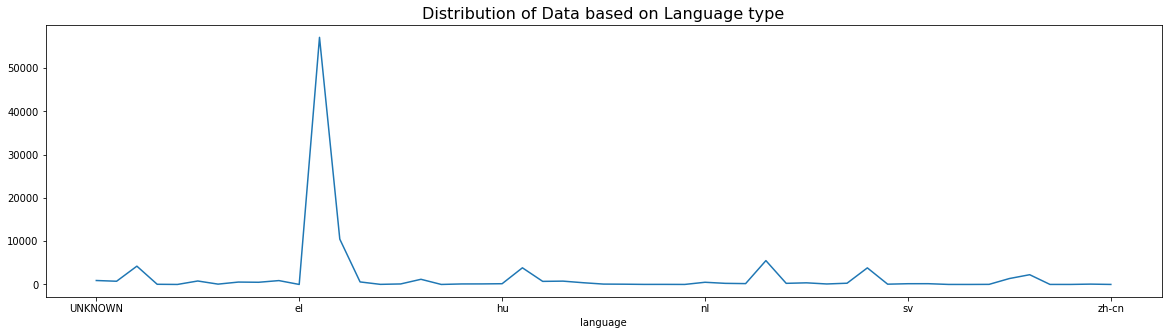

In [20]:
# Exploring the distribution of data based on variour language
df_tweets_lan.groupby("language")["language"].count().plot(figsize=(20,5))
plt.title("Distribution of Data based on Language type",fontsize=16)
plt.show()

In [21]:
language_distribution = df_tweets_lan.groupby(["language"]).agg({"language":["count"],"language_score":["mean"]})
language_distribution.columns =["language_tag","mean_language_score"]
language_distribution.head()

,language_tag,mean_language_score
language,,
UNKNOWN,911,0.000000
af,740,0.801851
ar,4227,0.988101
bg,39,0.853193
bn,1,1.000000


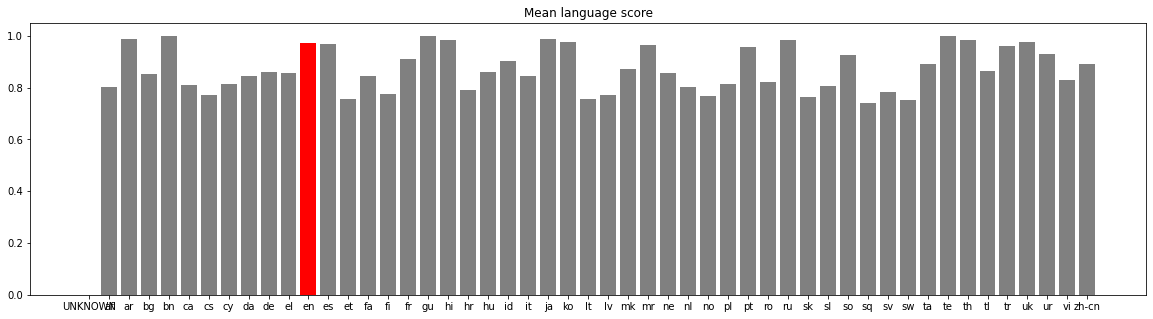

In [22]:
plt.figure(figsize=(20,5))
clr = ['grey' if (x !="en") else 'red' for x in language_distribution.index ]
plt.bar(x=language_distribution.index,height=language_distribution["mean_language_score"], color=clr)
plt.title("Mean language score")
plt.show()

Droping the Non-English tweet from the data set based on two criteria:
1. language_tag need to be `en`
2. the language_score need to be more than `0.8` 

In [23]:
df_tweets_en = df_tweets_lan[(df_tweets_lan.language =="en")&(df_tweets_lan.language_score >0.8)]
df_tweets_en.head()

,twitter_id,date,tweet,user_name,language,language_score
0,719681516645793794,2016-04-12 00:20:19+00:00,b'RT @NBCTheVoice: RT if you know you’re not t...,xtina,en,0.999997
1,183827908014514176,2012-03-25 08:09:23+00:00,"b'@DanMag94 slept til 5pm yesterday, that was ...",edsheeran,en,0.999996
3,892986468272144385,2017-08-03 05:52:19+00:00,b'Last day of filming today! 😬',carterreynolds,en,0.999996
4,1291330835048738817,2020-08-06 11:10:37+00:00,b'@obphil Thank you for having me as part of O...,garyvalenciano1,en,0.999994
5,1341165864310034432,2020-12-21 23:37:14+00:00,"b'Before you go to sleep tonight, make a wish....",jimmyfallon,en,0.999996


In [24]:
df_tweets_en.shape

(54231, 6)

##### **Handling the  special characters of the text and making `urls`,`emojis` , `#Tags` and `@ Tags` from the text data of the `tweet` column a new feature for future analysis**


Functions to handle special character of the text data

In [25]:
def text_filter(text):
  url =[]
  emojis_list=[]
  hash_tag=[]
  user_tag=[]

  # handle emojis
  emojis_list= list(emojis.get(text))

  # removing the  non-meaningful words
  text = re.sub('\n'," ",text)
  text = re.sub(r"^b'RT"," ",text)
  text = re.sub(r'^b"'," ",text)
  text = re.sub(r"^b'"," ",text)
  # text = re.sub(r'^rt'," ",text)

  # handling url
  url = re.findall('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+',text)

  # handling #tags
  hash_tag = re.findall('#[^\s]+',text)  

  # handling @usernames
  user_tag = re.findall('@[^\s]+',text)

  # removing hashtags , url , emojis and user tags from text
  text = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+',"",text, flags=re.IGNORECASE)
  text = re.sub('#[^\s]+','',text,flags=re.IGNORECASE) 
  text = re.sub('@[^\s]+','',text,flags=re.IGNORECASE)

  # removing any punctuation
  text = re.sub('[%s]'%re.escape(string.punctuation)," ",text)

  # removing any digit
  text = re.sub('\w*\d\w*'," ",text)


  # handling non_text
  non_text = re.findall(r'[^\w\s,]', text)
  text = ' '.join([str for str in text.split() if not any(i in str for i in non_text)])
  text = text.lower()

  return (text,url,emojis_list,hash_tag,user_tag)

Extracting the hash tags , user tags , url  into a new feature columnn and cleaning the `tweet` column from any special characters and digits

In [26]:
tweet_filter_one= df_tweets_en["tweet"].map(lambda x : list(text_filter(x)))
df_tweets_en["text"]= tweet_filter_one.map(lambda x : x[0])
df_tweets_en["url"]= tweet_filter_one.map(lambda x : x[1])
df_tweets_en["emojis"]= tweet_filter_one.map(lambda x : x[2])
df_tweets_en["hash_tag"]= tweet_filter_one.map(lambda x : x[3])
df_tweets_en["user_tag"]= tweet_filter_one.map(lambda x : x[4])

rows ,cols = df_tweets_en.shape
print(f"The Dataframe [Only with tweet language `EN`]  contains rows {rows} and {cols} Columns")

The Dataframe [Only with tweet language `EN`]  contains rows 54231 and 11 Columns


##### **Exploring the  empty data point after data preprocessing to handle the special characters of the text**

In [27]:
df_tweets_en[df_tweets_en["text"]==""].count()

twitter_id        1055
date              1055
tweet             1055
user_name         1055
language          1055
language_score    1055
text              1055
url               1055
emojis            1055
hash_tag          1055
user_tag          1055
dtype: int64

In [28]:
df_tweets_en.drop(df_tweets_en[df_tweets_en["text"]==""].index, inplace=True)
df_tweets_en.reset_index(inplace=True)

# droping the index column 
columns = list(df_tweets_en.columns)
columns.pop(0)
df_tweets_en =df_tweets_en[columns]
df_tweets_en.head()

rows ,cols = df_tweets_en.shape
print(f"The Dataframe [with  non empty text data]  contains rows {rows} and {cols} Columns")

The Dataframe [with  non empty text data]  contains rows 53176 and 11 Columns


**Note**: <br>
Based on above table , the `text` column contains 1224 rows of empty text as the orginal tweets rows may only contains url or hashtags or usertags . Therefore all the 1224 rows are dropped from futher analysis.

##### **Converting the emoji's from the `emoji` feature column into text data and store as a new feature column `emoji_text` and calculating the polarity score based on the type of emoji used per tweet**:

Function to convert emojis to Text

In [29]:
# coverting the emoticons into text
def emoji_demojize(data):
  emoji_text=[]
  words_pattern = '[a-z]+' 
  if(len(data)==0):
    return  emoji_text
  else :
    for emo in data:
      em = emoji.demojize(emo)
      em = re.findall(words_pattern, em, flags=re.IGNORECASE)
      em =" ".join(em)
      emoji_text.append(em)
    return emoji_text

###### Converting the emoji into text data

In [30]:
df_tweets_en["emoji_text"]= df_tweets_en["emojis"].map(lambda x : emoji_demojize(x))
df_tweets_en.sample(5)

,twitter_id,date,tweet,user_name,language,language_score,text,url,emojis,hash_tag,user_tag,emoji_text
32556,1114372735268945920,2019-04-06 03:42:18+00:00,b'SHARE OUR HEART FOR A BETTER FUTURE\nNEGERI ...,indrabektiasli,en,0.999995,share our heart for a better future negeri unt...,[https://t.co/4QSOlRotBI],[],[#IAMCHANGE],[],[]
46722,1346456492946427904,2021-01-05 14:00:18+00:00,b'@LuvFB_HateFifa @arlenephillips You’ll be su...,mrpeterandre,en,0.999997,be surprised how many people actually feel thi...,[],[],[],"[@LuvFB_HateFifa, @arlenephillips]",[]
40924,455469545071730688,2014-04-13 22:16:16+00:00,"b""I promise the next photo I post on insta won...",anselelgort,en,0.999995,i promise the next photo i post on insta won t...,[],[],[],[],[]
5817,1066841996289953792,2018-11-25 23:52:07+00:00,b'@Rob_Whitefield Brill enjoy 😊',johnbishop100,en,0.999996,brill enjoy,[],[😊],[],[@Rob_Whitefield],[smiling face with smiling eyes]
52910,1408077802142769166,2021-06-24 15:01:23+00:00,b'RT @SonyMusicSouth: Catch the maestro @arrah...,arrahman,en,0.857141,catch the maestro speak about with,[],[],"[#MeriPukaarSuno, #SadhanaSargam]","[@SonyMusicSouth:, @arrahman, @kschithra, @sas...",[]


##### **Calculating of the text data and creating two new features `text_subjectivity_score` and `text_polarity_score` to map the sentiment of the text**

In [31]:
# Calculating the subjectivity_score and polarity_score score of the text
def sentiment_analysis(text):
  subjectivity_score = TextBlob(text).sentiment.subjectivity
  polarity_score = TextBlob(text).sentiment.polarity
  return [subjectivity_score,polarity_score]

In [32]:
# Creating subjectivity_score and polarity_score score of the text
sentiment_analysis_result = df_tweets_en["text"].apply(lambda x: sentiment_analysis(x))
df_tweets_en["text_subjectivity_score"]= sentiment_analysis_result.map(lambda x : x[0])
df_tweets_en["text_polarity_score"]= sentiment_analysis_result.map(lambda x : x[1])
df_tweets_en.head(4)

,twitter_id,date,tweet,user_name,language,language_score,text,url,emojis,hash_tag,user_tag,emoji_text,text_subjectivity_score,text_polarity_score
0,719681516645793794,2016-04-12 00:20:19+00:00,b'RT @NBCTheVoice: RT if you know you’re not t...,xtina,en,0.999997,rt if you know not the only one voting for ton...,[https://t.co/KXuo6qsp6V],[],[#VoicePlayoffs],"[@NBCTheVoice:, @iamryanquinn]",[],1.000000,0.0
1,183827908014514176,2012-03-25 08:09:23+00:00,"b'@DanMag94 slept til 5pm yesterday, that was ...",edsheeran,en,0.999996,slept til yesterday that was alright,[],[],[],[@DanMag94],[],0.000000,0.0
2,892986468272144385,2017-08-03 05:52:19+00:00,b'Last day of filming today! 😬',carterreynolds,en,0.999996,last day of filming today,[],[😬],[],[],[grimacing face],0.066667,0.0
3,1291330835048738817,2020-08-06 11:10:37+00:00,b'@obphil Thank you for having me as part of O...,garyvalenciano1,en,0.999994,thank you for having me as part of ob the inde...,[],"[🙏, 💚, 😊]",[],[@obphil],"[folded hands, green heart, smiling face with ...",0.000000,0.0


#####**Sentiment analysis of the with `emoji_text` and the text data from `text` column together and creating a new features `text_emoji_polarity_score` based on the overall type of the emoji's used along with the text data per tweet**

In [33]:
# Combining the `text` with the `emoji_text` column  and evaluate the subjectivity and polarity score
text_emojitext_combined =pd.DataFrame()
text_emojitext_combined["text_emojitext_combined"] = df_tweets_en["emoji_text"].map(lambda x:" ".join(x))+" "+df_tweets_en["text"]
text_emojitext_combined_sentiment_analysis= text_emojitext_combined["text_emojitext_combined"].apply(lambda x: sentiment_analysis(x))
df_tweets_en["text_emojitext_combined_subjectivity_score"] = text_emojitext_combined_sentiment_analysis.map(lambda x:x[0])
df_tweets_en["text_emojitext_combined_polarity_score"] = text_emojitext_combined_sentiment_analysis.map(lambda x:x[1])
df_tweets_en.sample(5)

,twitter_id,date,tweet,user_name,language,language_score,text,url,emojis,hash_tag,user_tag,emoji_text,text_subjectivity_score,text_polarity_score,text_emojitext_combined_subjectivity_score,text_emojitext_combined_polarity_score
14753,1316508760764936193,2020-10-14 22:38:42+00:00,b'RT @SmoshGames: Thanks for registering to vo...,smosh,en,0.857139,thanks for registering to vote now we get 𝒷𝓁𝑜𝓃...,[https://t.co/DNLBJat8En],[✨],[],[@SmoshGames:],[sparkles],0.2,0.2,0.2,0.2
8078,713920818451972096,2016-03-27 02:49:21+00:00,b'@AlexAllTimeLow and yes I did just search th...,michael5sos,en,0.999997,and yes i did just search the internet for min...,[],[],[],[@AlexAllTimeLow],[],0.0,0.0,0.0,0.0
16955,1472699772435939331,2021-12-19 22:46:01+00:00,"b""@MichelleLGa You've now got me imagining a p...",jk_rowling,en,0.999996,you ve now got me imagining a plot that starts...,[car...],[],[],[@MichelleLGa],[],0.0,0.0,0.0,0.0
17388,888123801090670592,2017-07-20 19:49:49+00:00,b'@lawyerpwny @midnight Depends on where Boozy...,hardwick,en,0.999996,depends on where boozy lives,[],[],[],"[@lawyerpwny, @midnight]",[],0.0,0.0,0.0,0.0
43234,452017987139039232,2014-04-04 09:41:00+00:00,b'RT @KaDreamersWorld: “@KaDsDubai: Next frida...,imdanielpadilla,en,0.999996,next friday na daniel rocks with yeng,[http://t.co/tNbaXVwmpM],[],[],"[@KaDreamersWorld:, @KaDsDubai:]",[],0.0,0.0,0.0,0.0


##### **Mapping tweet pattern with respect to the hour of the day**

The entire day is grouped into four categories [detail mentioned in the table below) and based on the timestamp , each tweet is classified under one category as `1` and `0` for the remaining group.

Category Distribution <br>
1. Morining : 6am - 12am 
2. Afternoon : 12am - 6pm 
3. Evening : 6pm  - 12pm 
4. Night : 12pm - 6am 

Function to map the map the tweet pattern with repect to the time of the day

In [34]:
# Segementation of the data with respect to 6hr time interval
def tweet_time_patter(timestamp):
  hr_timestamp=[]
  if (timestamp>=6) & (timestamp<12):
    hr_timestamp =(1,0,0,0)
  elif (timestamp>=12) & (timestamp<18):
    hr_timestamp =(0,1,0,0)
  elif (timestamp>=18) & (timestamp<24):
    hr_timestamp =(0,0,1,0)
  else:
    hr_timestamp =(0,0,0,1)

  return hr_timestamp

In [35]:
#Creating the hour_timestamp_pattern
hour_timestamp_pattern =df_tweets_en["date"].dt.hour.apply(lambda x: list(tweet_time_patter(x)))
df_tweets_en["tw_morning"]=hour_timestamp_pattern.map(lambda x : x[0])
df_tweets_en["tw_afternoon"]=hour_timestamp_pattern.map(lambda x : x[1])
df_tweets_en["tw_evening"]=hour_timestamp_pattern.map(lambda x : x[2])
df_tweets_en["tw_night"]=hour_timestamp_pattern.map(lambda x : x[3])
df_tweets_en.shape

(53176, 20)

In [36]:
df_tweets_en.head()

,twitter_id,date,tweet,user_name,language,language_score,text,url,emojis,hash_tag,user_tag,emoji_text,text_subjectivity_score,text_polarity_score,text_emojitext_combined_subjectivity_score,text_emojitext_combined_polarity_score,tw_morning,tw_afternoon,tw_evening,tw_night
0,719681516645793794,2016-04-12 00:20:19+00:00,b'RT @NBCTheVoice: RT if you know you’re not t...,xtina,en,0.999997,rt if you know not the only one voting for ton...,[https://t.co/KXuo6qsp6V],[],[#VoicePlayoffs],"[@NBCTheVoice:, @iamryanquinn]",[],1.000000,0.0,1.000000,0.0,0,0,0,1
1,183827908014514176,2012-03-25 08:09:23+00:00,"b'@DanMag94 slept til 5pm yesterday, that was ...",edsheeran,en,0.999996,slept til yesterday that was alright,[],[],[],[@DanMag94],[],0.000000,0.0,0.000000,0.0,1,0,0,0
2,892986468272144385,2017-08-03 05:52:19+00:00,b'Last day of filming today! 😬',carterreynolds,en,0.999996,last day of filming today,[],[😬],[],[],[grimacing face],0.066667,0.0,0.066667,0.0,0,0,0,1
3,1291330835048738817,2020-08-06 11:10:37+00:00,b'@obphil Thank you for having me as part of O...,garyvalenciano1,en,0.999994,thank you for having me as part of ob the inde...,[],"[🙏, 💚, 😊]",[],[@obphil],"[folded hands, green heart, smiling face with ...",0.000000,0.0,0.300000,-0.2,1,0,0,0
4,1341165864310034432,2020-12-21 23:37:14+00:00,"b'Before you go to sleep tonight, make a wish....",jimmyfallon,en,0.999996,before you go to sleep tonight make a wish,[https://t.co/aOIZdCIg80],"[⭐, 🪐]",[],[],"[star, ringed planet]",0.000000,0.0,0.000000,0.0,0,0,1,0


#### **Feature engineering to address and identify the top level texting behaviour parameters of the users**

###### **Combining the text data from the `text` column with respect to  the user name to create text document per user**

In [37]:
# Creating the list of unique user name
user_name_list = df_tweets_en["user_name"].unique()
print(f"There are {len(user_name_list)} unique twitter users")

There are 811 unique twitter users


In [38]:
# Creating text corpus for each user by combinig all the tweet data into a single document
user_data =[]
for name in user_name_list:
  user_tweet = df_tweets_en[df_tweets_en["user_name"]==name]["text"]
  tweet = ''.join(user_tweet)
  user_data.append({"user_name":name,"text_document":tweet})

df_tweets_corpus=pd.DataFrame.from_records(user_data)
rows ,cols = df_tweets_corpus.shape
print(f"The corpus contains {rows} rows and {cols} Columns")

The corpus contains 811 rows and 2 Columns


In [39]:
df_tweets_corpus.head()

,user_name,text_document
0,xtina,rt if you know not the only one voting for ton...
1,edsheeran,slept til yesterday that was alrighti was chuf...
2,carterreynolds,last day of filming todayforever thankful for ...
3,garyvalenciano1,thank you for having me as part of ob the inde...
4,jimmyfallon,before you go to sleep tonight make a wishall ...


###### **Calculating the Average tweet Rate per week per user**

In [40]:
# calculating the tweet count per year per week per user 
user_tweet_rate_week_year=df_tweets_en.groupby(['user_name',
                                df_tweets_en['date'].dt.strftime('%Y'),
                                df_tweets_en['date'].dt.strftime('%W')]).agg({"user_name":["count"]})
user_tweet_rate_week_year.columns =["tweet_count"]
user_tweet_rate_week_year.index.names =['user_name', 'year', 'week_no']
user_tweet_rate_week_year = user_tweet_rate_week_year.reset_index()
user_tweet_rate_week_year.sample(frac=.2)

,user_name,year,week_no,tweet_count
31659,sleepinthegardn,2017,21,2
25355,normandesvideos,2016,50,1
5430,carmeloanthony,2017,13,1
27616,rampalarjun,2017,35,1
35461,usher,2021,19,1
...,...,...,...,...
34317,tomdaley1994,2016,49,2
15453,jessiej,2018,45,1
28756,robbiewilliams,2019,45,2
1082,akon,2019,15,1


In [41]:
# calculating the mean value of the tweet count per user 
tweet_rate_weekly = user_tweet_rate_week_year.groupby("user_name")["tweet_count"].mean()

In [42]:
# Updating the corpus with the average tweet rate per week 
df_tweets_corpus = pd.merge(df_tweets_corpus,tweet_rate_weekly,on=["user_name"])
df_tweets_corpus.rename(columns = {'tweet_count':'avg_weekly_tweet_count'}, inplace=True)
df_tweets_corpus.head()

,user_name,text_document,avg_weekly_tweet_count
0,xtina,rt if you know not the only one voting for ton...,1.275000
1,edsheeran,slept til yesterday that was alrighti was chuf...,3.116279
2,carterreynolds,last day of filming todayforever thankful for ...,1.166667
3,garyvalenciano1,thank you for having me as part of ob the inde...,1.413793
4,jimmyfallon,before you go to sleep tonight make a wishall ...,1.520548


###### **Calculating the average ratio of emoji usage to the average word count per user per tweet**<br>

In [43]:

# calculating the number of emojis per tweet and word count per tweet (excluding hashtags, urls,usertag and special character)
word_count=pd.DataFrame()
word_count["emoji_count_per_tweet"] = df_tweets_en["emojis"].map(lambda x:len(x))
word_count["word_count_per_tweet"] = df_tweets_en["text"].map(lambda x:len(x.split()))
word_count.head()

,emoji_count_per_tweet,word_count_per_tweet
0,0,11
1,0,6
2,1,5
3,3,14
4,2,9


In [44]:
# calculating the ratio of emoji usage to word count and adding to the mainpd.DataFrame `df_tweets_en` dataset as a new feature
word_count["ratio_emoji_words"] =word_count["emoji_count_per_tweet"]/word_count["word_count_per_tweet"] 
df_tweets_en["emoji_to_wordcount_ratio"] = word_count["ratio_emoji_words"]
df_tweets_en.head()

,twitter_id,date,tweet,user_name,language,language_score,text,url,emojis,hash_tag,...,emoji_text,text_subjectivity_score,text_polarity_score,text_emojitext_combined_subjectivity_score,text_emojitext_combined_polarity_score,tw_morning,tw_afternoon,tw_evening,tw_night,emoji_to_wordcount_ratio
0,719681516645793794,2016-04-12 00:20:19+00:00,b'RT @NBCTheVoice: RT if you know you’re not t...,xtina,en,0.999997,rt if you know not the only one voting for ton...,[https://t.co/KXuo6qsp6V],[],[#VoicePlayoffs],...,[],1.000000,0.0,1.000000,0.0,0,0,0,1,0.000000
1,183827908014514176,2012-03-25 08:09:23+00:00,"b'@DanMag94 slept til 5pm yesterday, that was ...",edsheeran,en,0.999996,slept til yesterday that was alright,[],[],[],...,[],0.000000,0.0,0.000000,0.0,1,0,0,0,0.000000
2,892986468272144385,2017-08-03 05:52:19+00:00,b'Last day of filming today! 😬',carterreynolds,en,0.999996,last day of filming today,[],[😬],[],...,[grimacing face],0.066667,0.0,0.066667,0.0,0,0,0,1,0.200000
3,1291330835048738817,2020-08-06 11:10:37+00:00,b'@obphil Thank you for having me as part of O...,garyvalenciano1,en,0.999994,thank you for having me as part of ob the inde...,[],"[🙏, 💚, 😊]",[],...,"[folded hands, green heart, smiling face with ...",0.000000,0.0,0.300000,-0.2,1,0,0,0,0.214286
4,1341165864310034432,2020-12-21 23:37:14+00:00,"b'Before you go to sleep tonight, make a wish....",jimmyfallon,en,0.999996,before you go to sleep tonight make a wish,[https://t.co/aOIZdCIg80],"[⭐, 🪐]",[],...,"[star, ringed planet]",0.000000,0.0,0.000000,0.0,0,0,1,0,0.222222


In [45]:
# calculating the average ratio of emoji usage to word count per user
avg_ratio_emoji_words_per_user = df_tweets_en.groupby(["user_name"]).agg({"emoji_to_wordcount_ratio":["mean"]})
avg_ratio_emoji_words_per_user.columns=["avg_emoji_to_wordcount_ratio"]
df_tweets_corpus = pd.merge(df_tweets_corpus,avg_ratio_emoji_words_per_user,on=["user_name"])
df_tweets_corpus.head(5)

,user_name,text_document,avg_weekly_tweet_count,avg_emoji_to_wordcount_ratio
0,xtina,rt if you know not the only one voting for ton...,1.275000,0.104284
1,edsheeran,slept til yesterday that was alrighti was chuf...,3.116279,0.042288
2,carterreynolds,last day of filming todayforever thankful for ...,1.166667,0.065314
3,garyvalenciano1,thank you for having me as part of ob the inde...,1.413793,0.134449
4,jimmyfallon,before you go to sleep tonight make a wishall ...,1.520548,0.024562


###### **Calculating the average word count per week per user**<br>

In [46]:
# calculating the total word count per tweet excluding the hashtags, emojis, usertags and urls 
wordcount_per_tweet = df_tweets_en["text"].map(lambda x:len(x.split()))
df_tweets_en["word_count_per_tweet"]= wordcount_per_tweet.map(lambda x : x)
df_tweets_en["word_count_per_tweet"].head()

0    11
1     6
2     5
3    14
4     9
Name: word_count_per_tweet, dtype: int64

In [47]:
# calculating the total word count  per week per per user 
total_count_week_year=df_tweets_en.groupby(['user_name',
                                df_tweets_en['date'].dt.strftime('%Y'),
                                df_tweets_en['date'].dt.strftime('%W')]).agg({"word_count_per_tweet":["sum"]})
total_count_week_year.columns =["total_word_count_per_week"]
total_count_week_year.index.names =['user_name', 'year', 'week_no']
total_count_week_year = total_count_week_year.reset_index()
total_count_week_year.head()

,user_name,year,week_no,total_word_count_per_week
0,10neto,2021,17,7
1,10ronaldinho,2016,32,7
2,10ronaldinho,2016,49,4
3,10ronaldinho,2017,01,4
4,10ronaldinho,2017,02,8


In [48]:
# Calculating the average word count per week per user 
average_word_cout_weekly = total_count_week_year.groupby("user_name")["total_word_count_per_week"].mean()
average_word_cout_weekly.head()

user_name
10neto              7.000000
10ronaldinho       10.571429
143redangel        14.368421
1loganhenderson    14.230769
21lva              18.153846
Name: total_word_count_per_week, dtype: float64

In [49]:
# Updating the corpus with the average tweet rate per week 
df_tweets_corpus = pd.merge(df_tweets_corpus,average_word_cout_weekly,on=["user_name"])
df_tweets_corpus.rename(columns ={'total_word_count_per_week':'avg_word_count_per_week'}, inplace=True)
df_tweets_corpus.head()

,user_name,text_document,avg_weekly_tweet_count,avg_emoji_to_wordcount_ratio,avg_word_count_per_week
0,xtina,rt if you know not the only one voting for ton...,1.275000,0.104284,16.537500
1,edsheeran,slept til yesterday that was alrighti was chuf...,3.116279,0.042288,38.209302
2,carterreynolds,last day of filming todayforever thankful for ...,1.166667,0.065314,9.928571
3,garyvalenciano1,thank you for having me as part of ob the inde...,1.413793,0.134449,26.189655
4,jimmyfallon,before you go to sleep tonight make a wishall ...,1.520548,0.024562,18.753425


###### **Calculating the User callout rate**

In [50]:
# calculating the number of user tag per tweet and word count per tweet.
callout_count=pd.DataFrame()
callout_count["callout_count_per_tweet"] = df_tweets_en["user_tag"].map(lambda x:len(x))
callout_count["word_count_per_tweet"] = df_tweets_en["text"].map(lambda x:len(x.split()))
callout_count.head()

,callout_count_per_tweet,word_count_per_tweet
0,2,11
1,1,6
2,0,5
3,1,14
4,0,9


In [51]:
# calculating the ratio of user tag usage to word count and adding to the mainpd.DataFrame `df_tweets_en` dataset as a new feature
callout_count["ratio_callout_words"] =callout_count["callout_count_per_tweet"]/callout_count["word_count_per_tweet"] 
df_tweets_en["usertag_to_wordcount_ratio"] = callout_count["ratio_callout_words"]
df_tweets_en.head()

,twitter_id,date,tweet,user_name,language,language_score,text,url,emojis,hash_tag,...,text_polarity_score,text_emojitext_combined_subjectivity_score,text_emojitext_combined_polarity_score,tw_morning,tw_afternoon,tw_evening,tw_night,emoji_to_wordcount_ratio,word_count_per_tweet,usertag_to_wordcount_ratio
0,719681516645793794,2016-04-12 00:20:19+00:00,b'RT @NBCTheVoice: RT if you know you’re not t...,xtina,en,0.999997,rt if you know not the only one voting for ton...,[https://t.co/KXuo6qsp6V],[],[#VoicePlayoffs],...,0.0,1.000000,0.0,0,0,0,1,0.000000,11,0.181818
1,183827908014514176,2012-03-25 08:09:23+00:00,"b'@DanMag94 slept til 5pm yesterday, that was ...",edsheeran,en,0.999996,slept til yesterday that was alright,[],[],[],...,0.0,0.000000,0.0,1,0,0,0,0.000000,6,0.166667
2,892986468272144385,2017-08-03 05:52:19+00:00,b'Last day of filming today! 😬',carterreynolds,en,0.999996,last day of filming today,[],[😬],[],...,0.0,0.066667,0.0,0,0,0,1,0.200000,5,0.000000
3,1291330835048738817,2020-08-06 11:10:37+00:00,b'@obphil Thank you for having me as part of O...,garyvalenciano1,en,0.999994,thank you for having me as part of ob the inde...,[],"[🙏, 💚, 😊]",[],...,0.0,0.300000,-0.2,1,0,0,0,0.214286,14,0.071429
4,1341165864310034432,2020-12-21 23:37:14+00:00,"b'Before you go to sleep tonight, make a wish....",jimmyfallon,en,0.999996,before you go to sleep tonight make a wish,[https://t.co/aOIZdCIg80],"[⭐, 🪐]",[],...,0.0,0.000000,0.0,0,0,1,0,0.222222,9,0.000000


In [52]:
# calculating the average ratio of emoji usage to word count per user
avg_ratio_usertag_words_per_user = df_tweets_en.groupby(["user_name"]).agg({"usertag_to_wordcount_ratio":["mean"]})
avg_ratio_usertag_words_per_user.columns=["avg_usertag_to_wordcount_ratio"]
df_tweets_corpus = pd.merge(df_tweets_corpus,avg_ratio_usertag_words_per_user,on=["user_name"])
df_tweets_corpus.head(5)

,user_name,text_document,avg_weekly_tweet_count,avg_emoji_to_wordcount_ratio,avg_word_count_per_week,avg_usertag_to_wordcount_ratio
0,xtina,rt if you know not the only one voting for ton...,1.275000,0.104284,16.537500,0.088513
1,edsheeran,slept til yesterday that was alrighti was chuf...,3.116279,0.042288,38.209302,0.167337
2,carterreynolds,last day of filming todayforever thankful for ...,1.166667,0.065314,9.928571,0.030483
3,garyvalenciano1,thank you for having me as part of ob the inde...,1.413793,0.134449,26.189655,0.122425
4,jimmyfallon,before you go to sleep tonight make a wishall ...,1.520548,0.024562,18.753425,0.148661


###### **Calculating the tweet pattern through out a day per user**<br>

In [53]:
# calculating the mean tweet per section of the day 
avg_tweet_pattern_day=df_tweets_en.groupby(["user_name"]).agg({"tw_morning":["sum"],"tw_afternoon":["sum"],"tw_evening":["sum"],"tw_night":["sum"]})
avg_tweet_pattern_day.columns=["total_tw_morning","total_tw_afternoon","total_tw_evening","total_tw_night"]
avg_tweet_pattern_day.head()

,total_tw_morning,total_tw_afternoon,total_tw_evening,total_tw_night
user_name,,,,
10neto,0,0,1,0
10ronaldinho,0,10,3,2
143redangel,17,13,2,13
1loganhenderson,10,15,41,28
21lva,2,7,4,0


In [54]:
df_tweets_corpus = pd.merge(df_tweets_corpus,avg_tweet_pattern_day,on=["user_name"])
df_tweets_corpus.head(5)

,user_name,text_document,avg_weekly_tweet_count,avg_emoji_to_wordcount_ratio,avg_word_count_per_week,avg_usertag_to_wordcount_ratio,total_tw_morning,total_tw_afternoon,total_tw_evening,total_tw_night
0,xtina,rt if you know not the only one voting for ton...,1.275000,0.104284,16.537500,0.088513,1,20,49,32
1,edsheeran,slept til yesterday that was alrighti was chuf...,3.116279,0.042288,38.209302,0.167337,31,63,37,3
2,carterreynolds,last day of filming todayforever thankful for ...,1.166667,0.065314,9.928571,0.030483,12,6,43,37
3,garyvalenciano1,thank you for having me as part of ob the inde...,1.413793,0.134449,26.189655,0.122425,29,19,4,30
4,jimmyfallon,before you go to sleep tonight make a wishall ...,1.520548,0.024562,18.753425,0.148661,5,55,20,31


###### **Calculating the hastag rate per user per tweet**<br>

In [55]:
# Calculating the number of hash tag per tweet and word count per tweet.
hashtag_count=pd.DataFrame()
hashtag_count["hasttag_count_per_tweet"] = df_tweets_en["hash_tag"].map(lambda x:len(x))
hashtag_count["word_count_per_tweet"] = df_tweets_en["text"].map(lambda x:len(x.split()))
hashtag_count.head()

,hasttag_count_per_tweet,word_count_per_tweet
0,1,11
1,0,6
2,0,5
3,0,14
4,0,9


In [56]:
# calculating the ratio of hash tag usage to word count and adding to the main DataFrame `df_tweets_en` dataset as a new feature
hashtag_count["ratio_hashtag_words"] = hashtag_count["hasttag_count_per_tweet"]/hashtag_count["word_count_per_tweet"] 
df_tweets_en["hashtag_to_wordcount_ratio"] = hashtag_count["ratio_hashtag_words"]
df_tweets_en.head()

,twitter_id,date,tweet,user_name,language,language_score,text,url,emojis,hash_tag,...,text_emojitext_combined_subjectivity_score,text_emojitext_combined_polarity_score,tw_morning,tw_afternoon,tw_evening,tw_night,emoji_to_wordcount_ratio,word_count_per_tweet,usertag_to_wordcount_ratio,hashtag_to_wordcount_ratio
0,719681516645793794,2016-04-12 00:20:19+00:00,b'RT @NBCTheVoice: RT if you know you’re not t...,xtina,en,0.999997,rt if you know not the only one voting for ton...,[https://t.co/KXuo6qsp6V],[],[#VoicePlayoffs],...,1.000000,0.0,0,0,0,1,0.000000,11,0.181818,0.090909
1,183827908014514176,2012-03-25 08:09:23+00:00,"b'@DanMag94 slept til 5pm yesterday, that was ...",edsheeran,en,0.999996,slept til yesterday that was alright,[],[],[],...,0.000000,0.0,1,0,0,0,0.000000,6,0.166667,0.000000
2,892986468272144385,2017-08-03 05:52:19+00:00,b'Last day of filming today! 😬',carterreynolds,en,0.999996,last day of filming today,[],[😬],[],...,0.066667,0.0,0,0,0,1,0.200000,5,0.000000,0.000000
3,1291330835048738817,2020-08-06 11:10:37+00:00,b'@obphil Thank you for having me as part of O...,garyvalenciano1,en,0.999994,thank you for having me as part of ob the inde...,[],"[🙏, 💚, 😊]",[],...,0.300000,-0.2,1,0,0,0,0.214286,14,0.071429,0.000000
4,1341165864310034432,2020-12-21 23:37:14+00:00,"b'Before you go to sleep tonight, make a wish....",jimmyfallon,en,0.999996,before you go to sleep tonight make a wish,[https://t.co/aOIZdCIg80],"[⭐, 🪐]",[],...,0.000000,0.0,0,0,1,0,0.222222,9,0.000000,0.000000


In [57]:
# calculating the average ratio of hash tag usage to word count per user
avg_ratio_hashtag_words_per_user = df_tweets_en.groupby(["user_name"]).agg({"hashtag_to_wordcount_ratio":["mean"]})
avg_ratio_hashtag_words_per_user.columns=["avg_hashtag_to_wordcount_ratio"]
df_tweets_corpus = pd.merge(df_tweets_corpus,avg_ratio_hashtag_words_per_user,on=["user_name"])
df_tweets_corpus.head(5)

,user_name,text_document,avg_weekly_tweet_count,avg_emoji_to_wordcount_ratio,avg_word_count_per_week,avg_usertag_to_wordcount_ratio,total_tw_morning,total_tw_afternoon,total_tw_evening,total_tw_night,avg_hashtag_to_wordcount_ratio
0,xtina,rt if you know not the only one voting for ton...,1.275000,0.104284,16.537500,0.088513,1,20,49,32,0.116599
1,edsheeran,slept til yesterday that was alrighti was chuf...,3.116279,0.042288,38.209302,0.167337,31,63,37,3,0.034418
2,carterreynolds,last day of filming todayforever thankful for ...,1.166667,0.065314,9.928571,0.030483,12,6,43,37,0.004426
3,garyvalenciano1,thank you for having me as part of ob the inde...,1.413793,0.134449,26.189655,0.122425,29,19,4,30,0.058053
4,jimmyfallon,before you go to sleep tonight make a wishall ...,1.520548,0.024562,18.753425,0.148661,5,55,20,31,0.103727


###### **Calculating the subjectivity score and polarity score of the text Document for each user**<br>

In [58]:
# Creating the text_document_subjectivity_score and text_document_polarity_score
sentiment_analysis_result_ul = df_tweets_corpus["text_document"].apply(lambda x: sentiment_analysis(x))
df_tweets_corpus["text_document_subjectivity_score"]= sentiment_analysis_result_ul.map(lambda x : x[0])
df_tweets_corpus["text_document_polarity_score"]= sentiment_analysis_result_ul.map(lambda x : x[1])
df_tweets_corpus.head(10)

,user_name,text_document,avg_weekly_tweet_count,avg_emoji_to_wordcount_ratio,avg_word_count_per_week,avg_usertag_to_wordcount_ratio,total_tw_morning,total_tw_afternoon,total_tw_evening,total_tw_night,avg_hashtag_to_wordcount_ratio,text_document_subjectivity_score,text_document_polarity_score
0,xtina,rt if you know not the only one voting for ton...,1.275000,0.104284,16.537500,0.088513,1,20,49,32,0.116599,0.515454,0.260985
1,edsheeran,slept til yesterday that was alrighti was chuf...,3.116279,0.042288,38.209302,0.167337,31,63,37,3,0.034418,0.507065,0.263272
2,carterreynolds,last day of filming todayforever thankful for ...,1.166667,0.065314,9.928571,0.030483,12,6,43,37,0.004426,0.547408,0.157227
3,garyvalenciano1,thank you for having me as part of ob the inde...,1.413793,0.134449,26.189655,0.122425,29,19,4,30,0.058053,0.541545,0.277148
4,jimmyfallon,before you go to sleep tonight make a wishall ...,1.520548,0.024562,18.753425,0.148661,5,55,20,31,0.103727,0.494741,0.206407
5,justdemi,we are together as much as we possibly can be ...,1.622951,0.005490,24.081967,0.096902,25,15,23,36,0.020424,0.536912,0.211908
6,icecube,tryouts are coming to chicago in one week this...,2.200000,0.021234,30.800000,0.050387,3,33,30,22,0.012279,0.482342,0.033305
7,ninadobrev,the past few days were so fun and i met some t...,1.190476,0.011383,14.460317,0.096199,5,14,32,24,0.093499,0.495629,0.198428
8,denise_richards,it s a scorchergoing down memory lane with thi...,1.387500,0.040940,13.637500,0.163621,12,16,25,58,0.109237,0.606126,0.334057
9,tomcruise,love knight and day one of my favorite moviest...,2.422222,0.001165,31.644444,0.158621,3,20,53,33,0.086071,0.558290,0.299160


###### **Calculating the subjectivity score and polarity score of the text document and emoji together for each user**<br>

In [59]:
# grouping the emoji text data together based on user name
user_data =[]
for name in user_name_list:
  user_tweet_text = df_tweets_en[df_tweets_en["user_name"]==name]["emoji_text"].map(lambda x: " ".join(x))
  emoji_text = ''.join(user_tweet_text)
  user_data.append({"user_name":name,"emoji_text_document":emoji_text})
emoji_text_combined_df =pd.DataFrame.from_records(user_data)
emoji_text_combined_df.head()

,user_name,emoji_text_document
0,xtina,clapping handswhite heartred heart kiss markhe...
1,edsheeran,sparklesblack heartmusical notesbutterflywoman...
2,carterreynolds,grimacing faceweary face snowboarderred heart ...
3,garyvalenciano1,folded hands green heart smiling face with smi...
4,jimmyfallon,star ringed planetopen bookwrapped gift booksd...


In [60]:
# Combining the `text_document` with the `emoji_text` column  and evaluate the subjectivity and polarity score
text_emojitext_combined_ul =pd.DataFrame()
text_emojitext_combined_ul["text_emojitext_combined"] = emoji_text_combined_df["emoji_text_document"]+" "+df_tweets_corpus["text_document"]
text_emojitext_combined_sentiment_analysis= text_emojitext_combined_ul["text_emojitext_combined"].apply(lambda x: sentiment_analysis(x))
df_tweets_corpus["text_document_emojitext_document_combined_subjectivity_score"] = text_emojitext_combined_sentiment_analysis.map(lambda x:x[0])
df_tweets_corpus["text_document_emojitext_document_combined_polarity_score"] = text_emojitext_combined_sentiment_analysis.map(lambda x:x[1])
df_tweets_corpus.head()

,user_name,text_document,avg_weekly_tweet_count,avg_emoji_to_wordcount_ratio,avg_word_count_per_week,avg_usertag_to_wordcount_ratio,total_tw_morning,total_tw_afternoon,total_tw_evening,total_tw_night,avg_hashtag_to_wordcount_ratio,text_document_subjectivity_score,text_document_polarity_score,text_document_emojitext_document_combined_subjectivity_score,text_document_emojitext_document_combined_polarity_score
0,xtina,rt if you know not the only one voting for ton...,1.275000,0.104284,16.537500,0.088513,1,20,49,32,0.116599,0.515454,0.260985,0.502614,0.255758
1,edsheeran,slept til yesterday that was alrighti was chuf...,3.116279,0.042288,38.209302,0.167337,31,63,37,3,0.034418,0.507065,0.263272,0.497049,0.249246
2,carterreynolds,last day of filming todayforever thankful for ...,1.166667,0.065314,9.928571,0.030483,12,6,43,37,0.004426,0.547408,0.157227,0.518307,0.140282
3,garyvalenciano1,thank you for having me as part of ob the inde...,1.413793,0.134449,26.189655,0.122425,29,19,4,30,0.058053,0.541545,0.277148,0.481952,0.195974
4,jimmyfallon,before you go to sleep tonight make a wishall ...,1.520548,0.024562,18.753425,0.148661,5,55,20,31,0.103727,0.494741,0.206407,0.485098,0.196510


##### **Calculating the impact of emitcons over the sentiment of the tweet**

In [61]:
# Calculating the impact of emitcons over the sentiment of the text
df_tweets_corpus["emoji_subjectivity_score"] = df_tweets_corpus["text_document_emojitext_document_combined_subjectivity_score"] - df_tweets_corpus["text_document_subjectivity_score"]
df_tweets_corpus["emoji_polarity_score"] = df_tweets_corpus["text_document_emojitext_document_combined_polarity_score"] - df_tweets_corpus["text_document_polarity_score"]
df_tweets_corpus["emoji_polarity_score"].head()


0   -0.005227
1   -0.014025
2   -0.016945
3   -0.081174
4   -0.009897
Name: emoji_polarity_score, dtype: float64

##### **Calculating the profanity score based on text document per user**<br>

In [62]:
#function calculating the profanity score of the text data
def profanity_score(text):
  censored_text = profanity.censor(text, '-')
  word_len = len(text.split())
  censored_count= censored_text.count('-')
  if censored_count==0:
    return censored_count
  else :
    score = censored_count/word_len
    return score

In [63]:
# creating the  profanity_score based on the over all text document.
df_tweets_corpus["profanity_score"]=df_tweets_corpus["text_document"].apply(lambda x: profanity_score(x))
df_tweets_corpus.head()

,user_name,text_document,avg_weekly_tweet_count,avg_emoji_to_wordcount_ratio,avg_word_count_per_week,avg_usertag_to_wordcount_ratio,total_tw_morning,total_tw_afternoon,total_tw_evening,total_tw_night,avg_hashtag_to_wordcount_ratio,text_document_subjectivity_score,text_document_polarity_score,text_document_emojitext_document_combined_subjectivity_score,text_document_emojitext_document_combined_polarity_score,emoji_subjectivity_score,emoji_polarity_score,profanity_score
0,xtina,rt if you know not the only one voting for ton...,1.275000,0.104284,16.537500,0.088513,1,20,49,32,0.116599,0.515454,0.260985,0.502614,0.255758,-0.012839,-0.005227,0.006547
1,edsheeran,slept til yesterday that was alrighti was chuf...,3.116279,0.042288,38.209302,0.167337,31,63,37,3,0.034418,0.507065,0.263272,0.497049,0.249246,-0.010017,-0.014025,0.005298
2,carterreynolds,last day of filming todayforever thankful for ...,1.166667,0.065314,9.928571,0.030483,12,6,43,37,0.004426,0.547408,0.157227,0.518307,0.140282,-0.029101,-0.016945,0.021710
3,garyvalenciano1,thank you for having me as part of ob the inde...,1.413793,0.134449,26.189655,0.122425,29,19,4,30,0.058053,0.541545,0.277148,0.481952,0.195974,-0.059593,-0.081174,0.050070
4,jimmyfallon,before you go to sleep tonight make a wishall ...,1.520548,0.024562,18.753425,0.148661,5,55,20,31,0.103727,0.494741,0.206407,0.485098,0.196510,-0.009643,-0.009897,0.000000


In [64]:
# Creating the user profile data set
user_profile_df=df_tweets_corpus[["user_name","text_document","avg_weekly_tweet_count","avg_word_count_per_week",
                                  "total_tw_morning","total_tw_afternoon","total_tw_evening","total_tw_night",
                                  "avg_emoji_to_wordcount_ratio","avg_usertag_to_wordcount_ratio",
                                  "avg_hashtag_to_wordcount_ratio","profanity_score",
                                  "text_document_subjectivity_score","text_document_polarity_score",
                                  "emoji_subjectivity_score","emoji_polarity_score"
                                  ]]
# Renaming the feature variables
user_profile_df.columns=["user_name","text_document","avg_weekly_twt_count","avg_word_count_per_week",
                                  "total_tw_morning","total_twt_afternoon","total_twt_evening","total_twt_night",
                                  "avg_emoji_wordcount_ratio","avg_usertag_wordcount_ratio",
                                  "avg_hashtag_wordcount_ratio","twt_profanity_score",
                                  "twt_subjectivity_score","twt_polarity_score",
                                  "emoji_subjectivity_score","emoji_polarity_score"]
user_profile_df.head()

,user_name,text_document,avg_weekly_twt_count,avg_word_count_per_week,total_tw_morning,total_twt_afternoon,total_twt_evening,total_twt_night,avg_emoji_wordcount_ratio,avg_usertag_wordcount_ratio,avg_hashtag_wordcount_ratio,twt_profanity_score,twt_subjectivity_score,twt_polarity_score,emoji_subjectivity_score,emoji_polarity_score
0,xtina,rt if you know not the only one voting for ton...,1.275000,16.537500,1,20,49,32,0.104284,0.088513,0.116599,0.006547,0.515454,0.260985,-0.012839,-0.005227
1,edsheeran,slept til yesterday that was alrighti was chuf...,3.116279,38.209302,31,63,37,3,0.042288,0.167337,0.034418,0.005298,0.507065,0.263272,-0.010017,-0.014025
2,carterreynolds,last day of filming todayforever thankful for ...,1.166667,9.928571,12,6,43,37,0.065314,0.030483,0.004426,0.021710,0.547408,0.157227,-0.029101,-0.016945
3,garyvalenciano1,thank you for having me as part of ob the inde...,1.413793,26.189655,29,19,4,30,0.134449,0.122425,0.058053,0.050070,0.541545,0.277148,-0.059593,-0.081174
4,jimmyfallon,before you go to sleep tonight make a wishall ...,1.520548,18.753425,5,55,20,31,0.024562,0.148661,0.103727,0.000000,0.494741,0.206407,-0.009643,-0.009897


In [65]:
# Saving the feature data into a pickle file for EDA 
with open('/content/drive/MyDrive/BrainStation/user_profile_df.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(user_profile_df, file)


#### **Exploratory Data Analysis**
- Time data analysis
  1. How frequently a user tweets and what is the rate per week?
  2. What is the tweet pattern of a user per day?
  3. How many words a user text per week?
- Sentiment analysis
  1. How strongly a positive or a negative emotion is associated with the text data? How the text data is influenced by the presence of the emoticons?
  2. What is the amount of personal opinion and factual information contained in the text? Is there any impact of the emoticons?
- Analysis of Emoticons, URLs, #hashtags and @usertags in texting usage
  1. How often does a user takes support of the emoticons to express their feelings while texting?
  2. How often does a user addresses the issues which are trending in the platform?
  3. How often does a user refers to other people or content to express what they wish to convey?
- Profanity  analysis
  1. What is the level of inappropriate language a user uses in their tweets?
- Exploring the Correlation between features



In [66]:
# Loading the prepocessed data 
user_profile_df = pd.read_pickle("/content/drive/MyDrive/BrainStation/user_profile_df.pkl")
user_profile_df.head()

,user_name,text_document,avg_weekly_twt_count,avg_word_count_per_week,total_tw_morning,total_twt_afternoon,total_twt_evening,total_twt_night,avg_emoji_wordcount_ratio,avg_usertag_wordcount_ratio,avg_hashtag_wordcount_ratio,twt_profanity_score,twt_subjectivity_score,twt_polarity_score,emoji_subjectivity_score,emoji_polarity_score
0,xtina,rt if you know not the only one voting for ton...,1.275000,16.537500,1,20,49,32,0.104284,0.088513,0.116599,0.006547,0.515454,0.260985,-0.012839,-0.005227
1,edsheeran,slept til yesterday that was alrighti was chuf...,3.116279,38.209302,31,63,37,3,0.042288,0.167337,0.034418,0.005298,0.507065,0.263272,-0.010017,-0.014025
2,carterreynolds,last day of filming todayforever thankful for ...,1.166667,9.928571,12,6,43,37,0.065314,0.030483,0.004426,0.021710,0.547408,0.157227,-0.029101,-0.016945
3,garyvalenciano1,thank you for having me as part of ob the inde...,1.413793,26.189655,29,19,4,30,0.134449,0.122425,0.058053,0.050070,0.541545,0.277148,-0.059593,-0.081174
4,jimmyfallon,before you go to sleep tonight make a wishall ...,1.520548,18.753425,5,55,20,31,0.024562,0.148661,0.103727,0.000000,0.494741,0.206407,-0.009643,-0.009897


##### **Time Data Analysis**

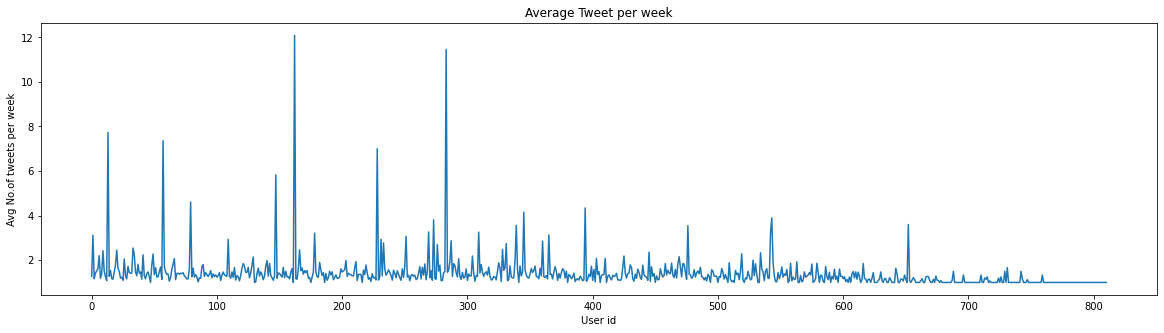

In [67]:
# Exploring the average weekly tweet count per user
user_profile_df.sort_values(["avg_weekly_twt_count"],ascending=False)

# Visualizing the distribution of average weekly tweet count per user
mean=user_profile_df["avg_weekly_twt_count"].mean()
plt.figure(figsize=[20,5])
sns.lineplot(data =user_profile_df["avg_weekly_twt_count"])
plt.ylabel("Avg No.of tweets per week")
plt.xlabel("User id")
plt.title("Average Tweet per week")
plt.show()

It is clear that the users with a verified account are not very frequent in posting tweets as the range varies between 1 - 3 tweets per week, however, there are expectations like Neil Gaiman, who pushes the limit upto 12

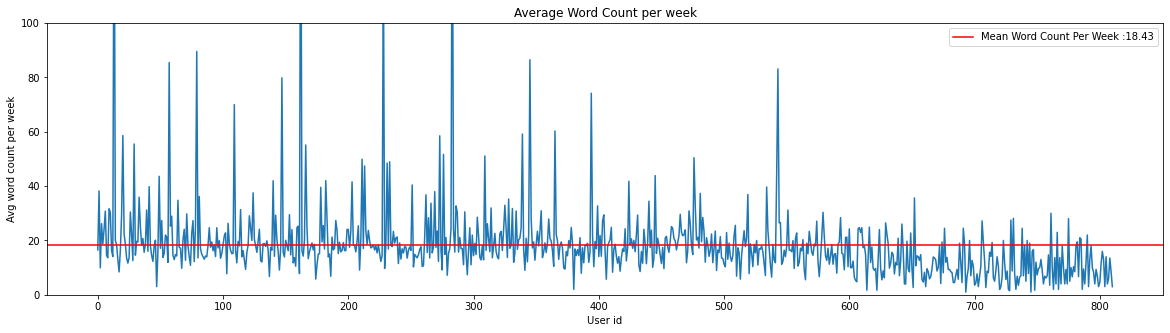

In [68]:
#Exploring the Average word count per user per week 
mean=user_profile_df["avg_word_count_per_week"].mean()

# Visualizing the distribution of average word count per user per week
plt.figure(figsize=[20,5])
sns.lineplot(data =user_profile_df["avg_word_count_per_week"])
plt.axhline(mean, color="red",label=f"Mean Word Count Per Week :{round(mean,2)}")
plt.ylabel("Avg word count per week")
plt.xlabel("User id")
plt.title("Average Word Count per week")
plt.ylim(0,100)
plt.legend()
plt.show()

The range of 18 to 20 words per week is considered as the average word count per week. There is  also a positive correlation between the word count and the number of tweets per week. Therefore the average tweet per week is dropped from the final feature matrix.

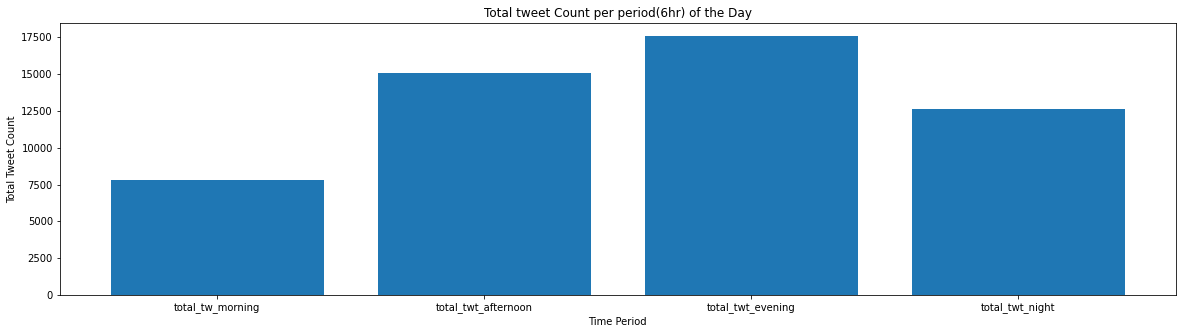

In [69]:
#Exploring the tweet pattern across the day for all users
tweet_day_pattern = user_profile_df[["total_tw_morning",	"total_twt_afternoon",	"total_twt_evening",	"total_twt_night"]].sum()

# Visualizing the relationship between tweet count and hour of the day
plt.figure(figsize=[20,5])
plt.bar(tweet_day_pattern.index,tweet_day_pattern.values)
plt.xlabel("Time Period")
plt.ylabel("Total Tweet Count")
plt.title("Total tweet Count per period(6hr) of the Day")
plt.show()

It looks like evening time i.e. the time between 6pm - 12am is the time when the users mostly tweet, followed by afternoon i.e. 12pm - 6pm.

##### **Sentiment Analysis**

1. Subjectivity score

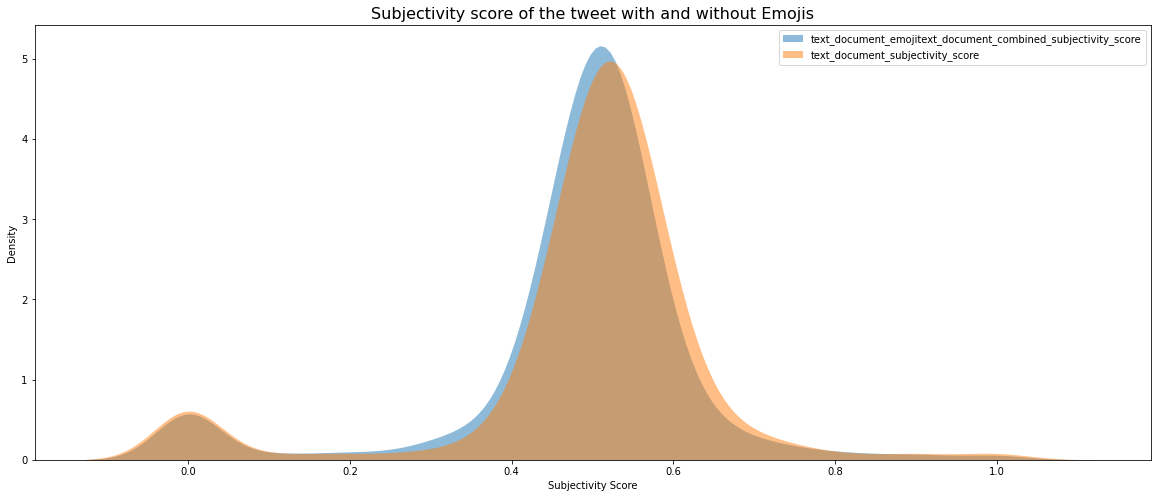

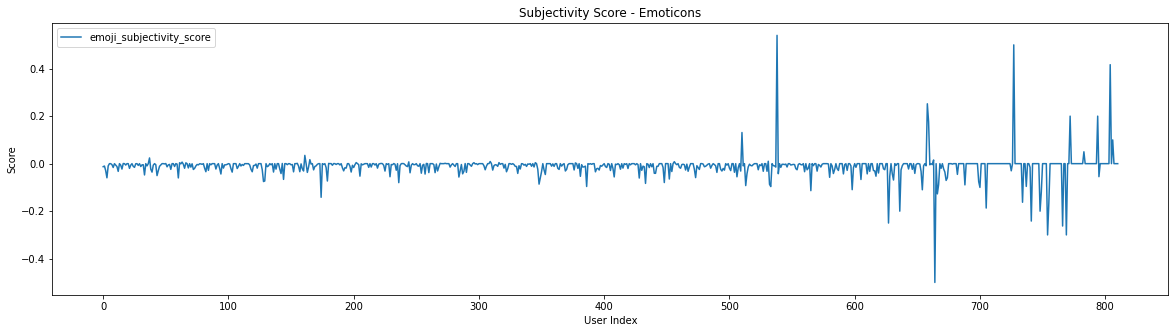

In [70]:
# visualizing the subjectivity score difference between text data and text data woth emoji text
plt.figure(figsize=[20,8])
sns.kdeplot(
   data=df_tweets_corpus, x="text_document_emojitext_document_combined_subjectivity_score", 
   fill=True,  palette="crest",
   alpha=.5, linewidth=0,
   label ="text_document_emojitext_document_combined_subjectivity_score"
)
sns.kdeplot(
   data=df_tweets_corpus, x="text_document_subjectivity_score", 
   fill=True,  palette="crest",
   alpha=.5, linewidth=0,
   legend="text_document_subjectivity_score",
   label="text_document_subjectivity_score"
)

plt.xlabel("User Profile index")
plt.xlabel("Subjectivity Score")
plt.title("Subjectivity score of the tweet with and without Emojis",fontsize=16)
plt.legend()
plt.show()

# Exploring the subjectivity score of the Emoticons in isolation
df_tweets_corpus[["emoji_subjectivity_score"]].plot(kind="line",figsize=[20,5])
plt.xlabel("User Index")
plt.ylabel("Score")
plt.title("Subjectivity Score - Emoticons")
plt.show()

The density plot strongly indicates that twitter acts as an platform for people to be very opinionated about what they text. And the Emoticons similar to the polarity plot holds a marginal but consistent influence all across. In some cases, it also strongly changes the score. Therefore, both, subjectivity of text and emoticons are considered as new features for analysis.


2. Polarity Score

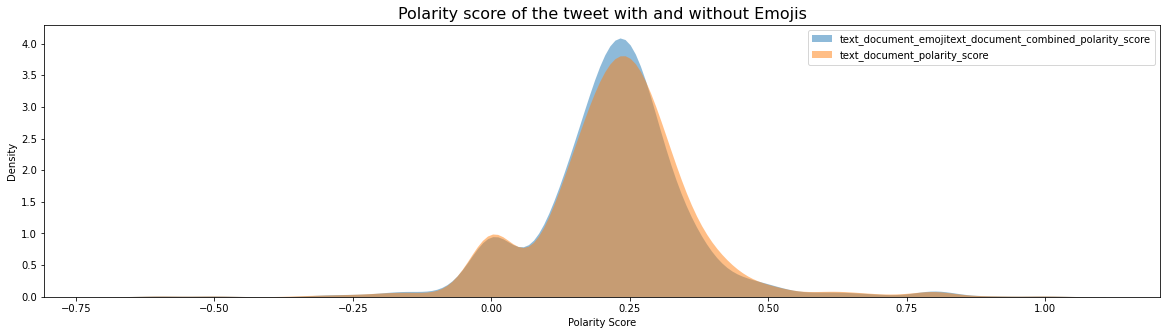

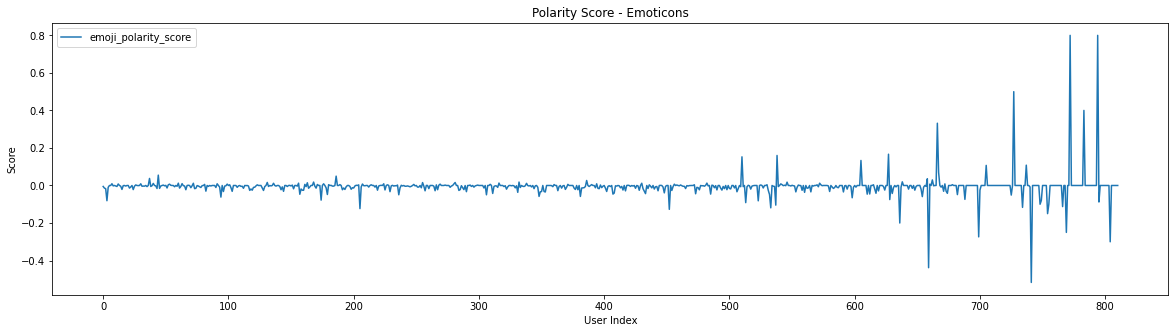

In [71]:
# visualizing the subjectivity score difference between text data and text data woth emoji text
plt.figure(figsize=[20,5])
sns.kdeplot(
   data=df_tweets_corpus, x="text_document_emojitext_document_combined_polarity_score", 
   fill=True,  palette="crest",
   alpha=.5, linewidth=0,
   legend="text_document_emojitext_document_combined_polarity_score",
   label="text_document_emojitext_document_combined_polarity_score"
)
sns.kdeplot(
   data=df_tweets_corpus, x="text_document_polarity_score", 
   fill=True,  palette="crest",
   alpha=.5, linewidth=0,
   label="text_document_polarity_score"
)
plt.xlabel("User Profile index")
plt.xlabel("Polarity Score")
plt.title("Polarity score of the tweet with and without Emojis",fontsize=16)
plt.legend()
plt.show()

# Exploring the polarity score of the Emoticons in isolation
df_tweets_corpus[["emoji_polarity_score"]].plot(kind="line",figsize=[20,5])
plt.xlabel("User Index")
plt.ylabel("Score")
plt.title("Polarity Score - Emoticons")
plt.show()

The above plot indicates that the polarity score with only text, majorly lies between the range of -0.25 to 0.5. When compared with the text with emoticons, the score changes marginally, but in an consistent manner. This leads to the conclusion that emoticons can be considered a distinct feature which impacts the polarity score of texting 


#####**Analysis of the Emoticons, URLs, #hashtags and @usertags in texting usage**

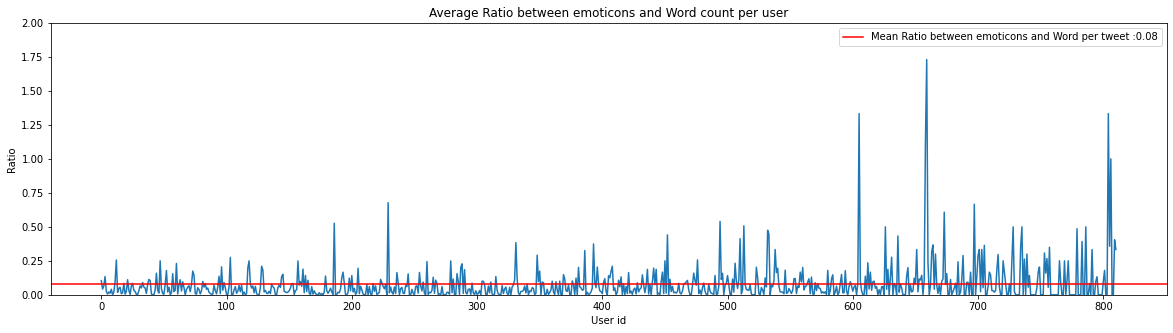

In [72]:
#Exploring and Visualizing the average ratio between emoticons and Word count per user.
mean=user_profile_df["avg_emoji_wordcount_ratio"].mean()

plt.figure(figsize=[20,5])
sns.lineplot(data =user_profile_df["avg_emoji_wordcount_ratio"])
plt.axhline(mean, color="red",label=f"Mean Ratio between emoticons and Word per tweet :{round(mean,2)}")
plt.ylabel("Ratio")
plt.xlabel("User id")
plt.title("Average Ratio between emoticons and Word count per user")
plt.ylim(0,2)
plt.legend()
plt.show()

With the mean ration between emoticons  and word count per tweet more than 9%  , along with the result of sentiment analysis, it is clearly indicates that the emoticons are considered significantly  while texting Therefore, mean ration between emoticons  and word count per tweet considered as one of the key features of the matrix for future analysis.

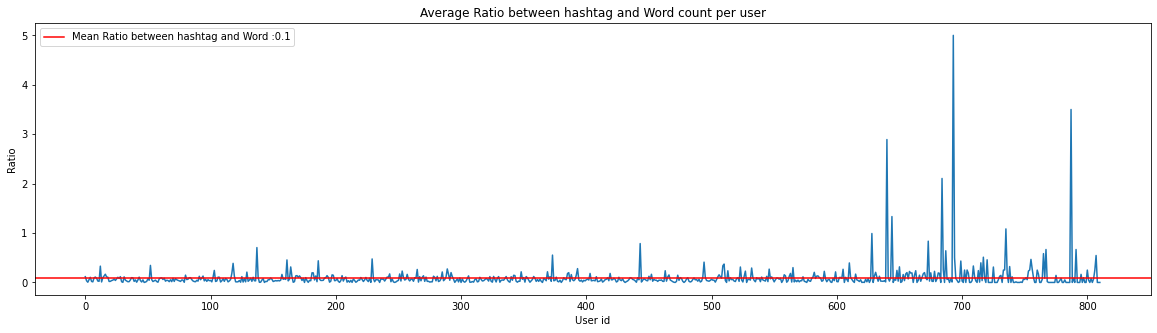

In [73]:
#Exploring and Visualizing the Mean Ratio between hashtag and Word count.
mean=user_profile_df["avg_hashtag_wordcount_ratio"].mean()


plt.figure(figsize=[20,5])
sns.lineplot(data =user_profile_df["avg_hashtag_wordcount_ratio"])
plt.axhline(mean, color="red",label=f"Mean Ratio between hashtag and Word :{round(mean,2)}")
plt.ylabel("Ratio")
plt.xlabel("User id")
plt.title("Average Ratio between hashtag and Word count per user")
plt.legend()
plt.show()

The plot shows that the users have a consistent inclination to engage with current issues. Apart from a few exceptions, the overall trend lies in the range of 9-10%.Therefore mean ration between hashtag count and word count is considered to understand the user’s behavior to address the  with trending issues  while texting.

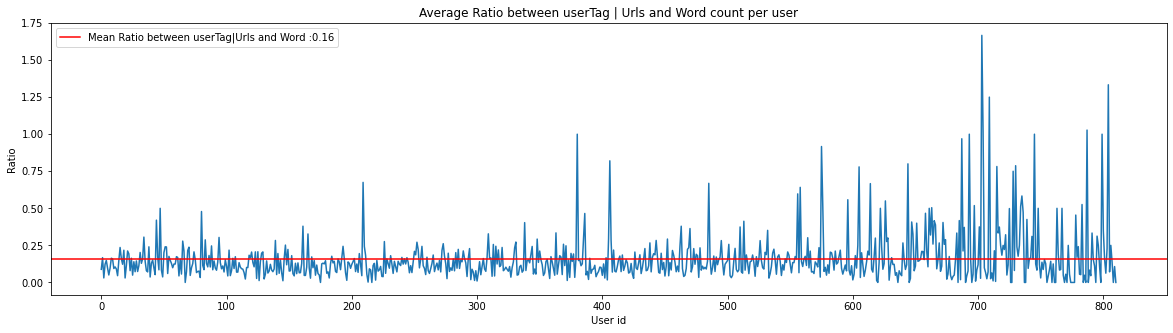

In [74]:
#Exploring and Visualizing the Mean Ratio between userTag|Urls and Word.
mean=user_profile_df["avg_usertag_wordcount_ratio"].mean()

plt.figure(figsize=[20,5])
sns.lineplot(data =user_profile_df["avg_usertag_wordcount_ratio"])
plt.axhline(mean, color="red",label=f"Mean Ratio between userTag|Urls and Word :{round(mean,2)}")
plt.ylabel("Ratio")
plt.xlabel("User id")
plt.title("Average Ratio between userTag | Urls and Word count per user")
plt.legend()
plt.show()

The users have a strong inclination to refer to other people and other content to express themselves in the platform.Also, it is also observed that this feature had a similar pattern as the previous two features i.e the user id ranging 600 - 800 are more active in terms of referring to other people and other content to express themselves.

#####**Analysis of the Profanity score**

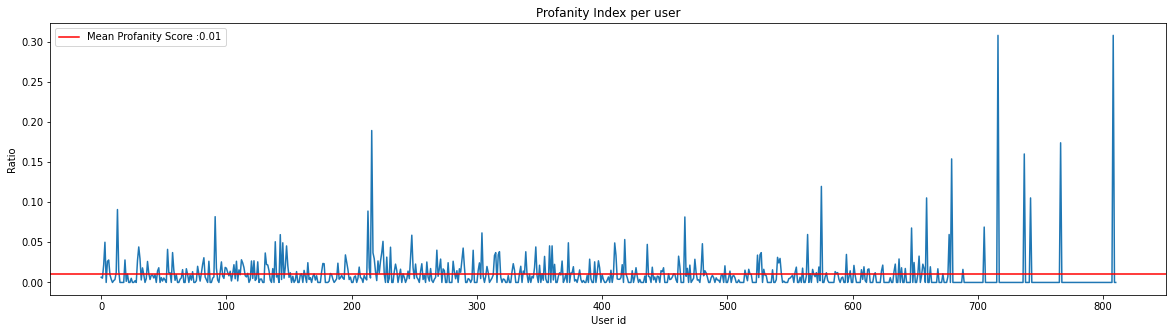

In [75]:
#Exploring and Visualizing the frequency of inappropriate language a user uses in their tweets

mean=user_profile_df["twt_profanity_score"].mean()
plt.figure(figsize=[20,5])
sns.lineplot(data =user_profile_df["twt_profanity_score"])
plt.axhline(mean, color="red",label=f"Mean Profanity Score :{round(mean,2)}")
plt.ylabel("Ratio")
plt.xlabel("User id")
plt.title("Profanity Index per user")
plt.legend()
plt.show()

The profanity score indicates that there are two sections of verified account users, where, the first category, the dominant ones, are more civil about what they tweet, however, the second category frequently uses inappropriate language to raise their opinion about issues. This makes this feature a categorical variable to evaluate the texting behavior 


##### **Exploring the Correlation among the top level feature matrix**

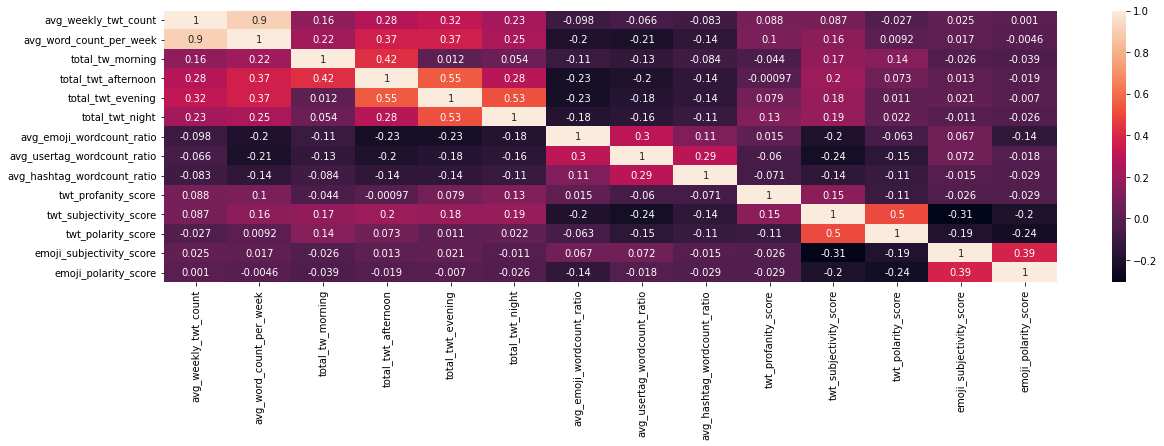

In [76]:
# Exploring the Correlation between the top level feature matrix
plt.figure(figsize=[20,5])
sns.heatmap(user_profile_df.corr(),annot=True)
plt.show()

Based on the heat map, it is observed that the average weekly tweet count with average word count per week has a strong correlation. Similarly, the polarity score also shows a strong correlation with the subjectivity score in both the cases (text with emoticons and only text). Therefore, one feature from both the sets are dropped for further analysis.

In [77]:
# dropping the avg_weekly_twt_count,twt_subjectivity_score and emoji_subjectivity_score as the correlation value is above 0.5
user_profile_df.drop(["avg_weekly_twt_count","twt_subjectivity_score","emoji_subjectivity_score"],axis =1,inplace=True)
rows ,cols = user_profile_df.shape
print(f"The top level feature matrix set contains {rows} users  with {cols} features")

The top level feature matrix set contains 811 users  with 13 features


#### **Summary**
Based on all the data cleaning , analysis and feature engerring techniques , the feature matrix created address's the top level texting behaviour.<br/>
The following  data Dictionary explain the feature name and its descriptions in detail for future analysis.

**Data Dictionary**
1.   `user_name` : The screen name of the user 
2.   `text_document`: The overall text data combined into a single text document
3.   `avg_word_count_per_week` : The average number of word typed per week 
4.   `total_tw_morning`: Total number of tweet posted in the morning from 6am - 12am
5.   `total_twt_afternoon`: Total number of tweet posted in the morning from 12pm - 6pm
6.   `total_twt_evening` : Total number of tweet posted in the afternoon from 6pm - 12pm
7.   `total_twt_night`: Total number of tweet posted in the morning from 12pm - 6am
8.   `avg_emoji_wordcount_ratio` : The average ratio of emoji used  to the total number of word used per tweet 
9.   `avg_usertag_wordcount_ratio` : The average ratio of user call out to the total number of word used per tweet 
10.   `avg_hashtag_wordcount_ratio`: The average ratio of key words used in the form of hash tags to the total number of word used per tweet 
11.   `twt_profanity_score`: The ratio of overall usage of language that includes dirty words and ideas vs the text document word count
12.   `twt_polarity_score`: Tweet including only the text, having a strong positive feeling or emotion associated with it
13.   `emoji_polarity_score` : difference of polarity score with and without emoji in the text data

##### **Saving the preprocessing tweet level data and the user level corpus data as pickel file**

In [78]:
# Corpus level data 
with open('/content/drive/MyDrive/BrainStation/user_profile_df.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(user_profile_df, file)
